### Clustering with HMMs

From: Clustering Sequences with Hidden Markov Models by Padhraic Smyth


https://papers.nips.cc/paper/1217-clustering-sequences-with-hidden-markov-models.pdf

In [1]:
import sys
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.mixture
import sklearn.cluster
import sklearn.model_selection
import scipy.cluster
import scipy.spatial
import pandas as pd

In [2]:
sns.set()

In [3]:
sys.path.insert(0, "..")


In [4]:
from hmm import GaussianHMM, distance, plots, PoissonHMM, CategoricalHMM, CategoricalVariationalHMM, GaussianVariationalHMM, HMMCluster
from hmm.datasets import synthetic

In [5]:
pi_1 = [.5, .5]

A_1 = [[.6, .4],
       [.4, .6]]
means_1 = [0, 4]
var_1 = [2, 1]
pi_2 = pi_1
A_2 = [[.4, .6],
      [.6, .4]]
means_2 = means_1
var_2 = var_1

In [6]:
n_clusters = 2
n_states = 2

### Generate sequences from two HMMS
The only differences are in the hidden state transition matrices.  The emissions are the same.

In [7]:

model_1 = GaussianHMM.GaussianHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_1.pi_ = pi_1
model_1.A_ = A_1
model_1.means_ = means_1
model_1.variances_ = var_1
model_2 = GaussianHMM.GaussianHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_2.pi_ = pi_2
model_2.A_ = A_2
model_2.means_ = means_2
model_2.variances_ = var_2

In [8]:
observed_1, hidden_1 = model_1.sample(1, 200)
observed_2, hidden_2 = model_2.sample(1, 200)

### Sample Sequence from Model 1

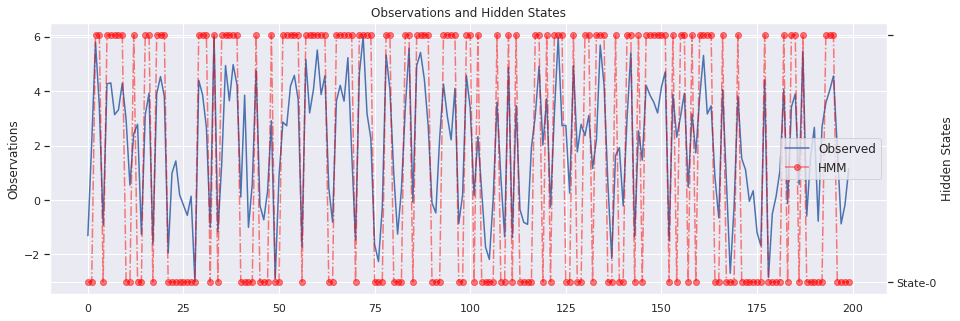

In [9]:
_ = plots.plot_hmm_states(observed_1[0], hidden_1[0])

### Sample Sequence from Model 2

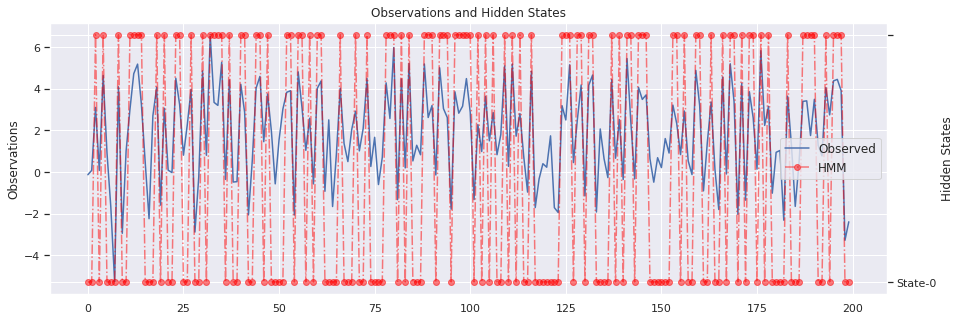

In [10]:
_ = plots.plot_hmm_states(observed_2[0], hidden_2[0])

### Distribution of values
Both sampled sequences have similar observation value distributions

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


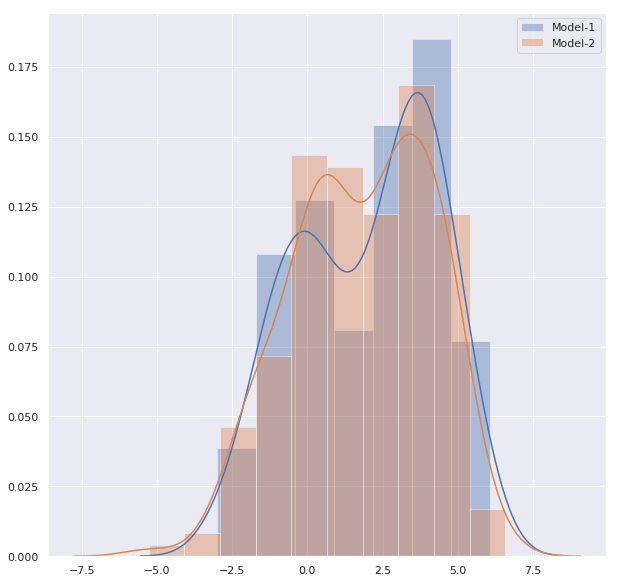

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
sns.distplot(observed_1, label="Model-1", ax=ax)
sns.distplot(observed_2, label="Model-2", ax=ax)
ax.legend(loc="best")


In [12]:
observed_1.T

array([[-1.31286144],
       [ 2.07272455],
       [ 5.7972855 ],
       [ 3.43958259],
       [-0.9235282 ],
       [ 4.27050292],
       [ 4.30046485],
       [ 3.13527644],
       [ 3.31386294],
       [ 4.28952009],
       [ 2.94662617],
       [ 0.54647683],
       [ 2.43206348],
       [ 2.78309063],
       [-1.26118496],
       [ 3.1215765 ],
       [ 3.93073432],
       [-1.62065661],
       [ 3.90297231],
       [ 4.53406405],
       [ 3.80089188],
       [-1.94540074],
       [ 0.98602969],
       [ 1.43563694],
       [ 0.1878052 ],
       [-0.18844192],
       [-0.56165721],
       [ 0.13900052],
       [-3.00925694],
       [ 4.39366446],
       [ 3.86489004],
       [ 2.65936467],
       [-1.01295203],
       [ 6.06687915],
       [-1.16493512],
       [ 1.3249469 ],
       [ 4.93988036],
       [ 3.64688893],
       [ 4.97337123],
       [ 4.23233188],
       [ 0.11135942],
       [ 3.85090072],
       [-1.00246104],
       [ 0.5854177 ],
       [ 4.76628757],
       [-0

### Generate sample data

In [13]:
def sample_and_split(models, n_samples = 100, sample_lengths=200):

    observations = []
    labels = []
    
    for i, m in enumerate(models):
        labels += [i] * n_samples
        observed, _ = m.sample(n_samples, sample_lengths)
        observations += observed.tolist()
    observations = np.asarray(observations)

    train_idx, test_idx = sklearn.model_selection.train_test_split(np.arange(observations.shape[0]), test_size=.7, stratify=labels)

    test_labels = np.asarray([labels[i] for i in test_idx])
    train_labels = np.asarray([labels[i] for i in train_idx])

    test_observations = observations[test_idx]
    training_observations = observations[train_idx]
    return training_observations, test_observations, train_labels, test_labels



### Cluster the sequences

* Train an hmm on each sequence
* Then use a distance-based clustering algorith on the distance of each per-sequence-hmm.
* Then train models on the clusters of sequences
* Further fit the models on groups of sequences.
* Build a composite model with block-diagonal transition matrices.

In [14]:
train_observations, test_observations, train_labels, test_labels = sample_and_split([model_1, model_2])

In [15]:
clusterer = HMMCluster.HMMDistanceCluster(
    n_clusters=2, 
    n_iterations_1=200,
    n_iterations_2=400,
    hmm_impl=GaussianHMM.GaussianHMM(
        n_components=2, 
        tol=1e-6, 
        n_inits=1, 
        verbose=0, 
        implementation="scaling"
    ),
)

In [16]:
print(train_labels)

[1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0
 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0]


In [17]:
indices = np.argsort(train_labels)
train_labels[indices]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
clusterer.fit(train_observations)

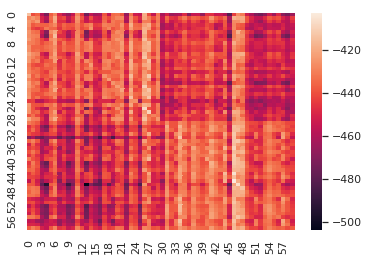

In [19]:
sns.heatmap(clusterer.original_lls_[indices][:, indices])

In [20]:
lls = clusterer.original_lls_.copy()

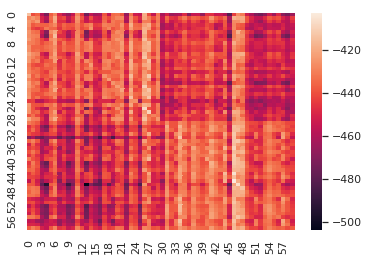

In [21]:
sns.heatmap(lls[indices][:, indices])

In [22]:
scaled = sklearn.preprocessing.minmax_scale(-1 * lls)#[indices][:, indices])

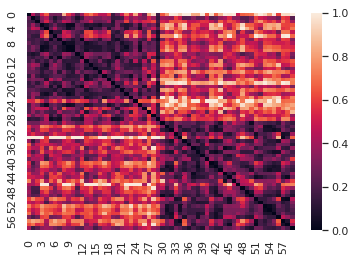

In [23]:
sns.heatmap(scaled[indices][:, indices])

In [24]:
scaled += scaled.T
scaled /=2

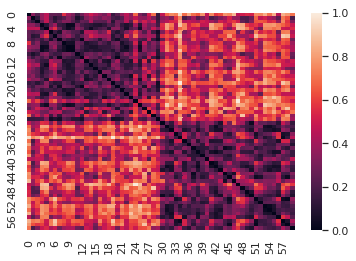

In [25]:
sns.heatmap(scaled[indices][:, indices])

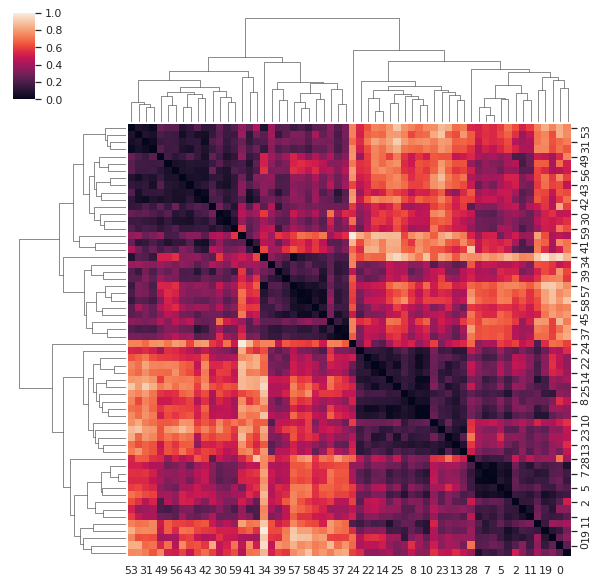

In [26]:
sns.clustermap(scaled[indices][:, indices])

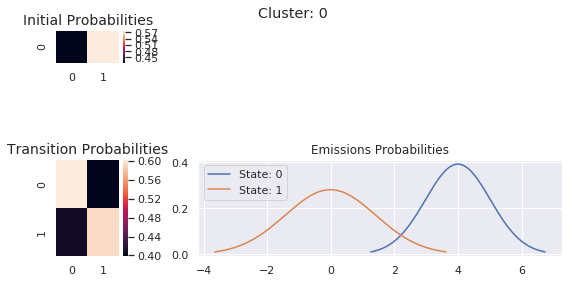

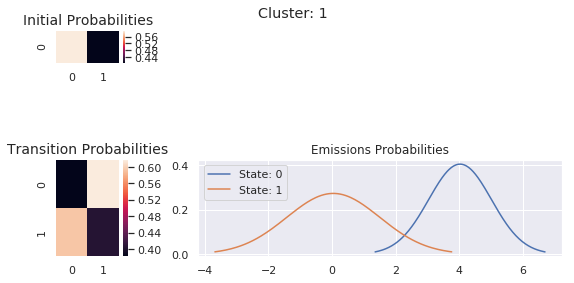

In [27]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.gaussian_hinton_diagram(
        m.pi_,
        m.A_,
        m.means_,
        m.variances_
    )
    fig.suptitle("Cluster: {}".format(i))

In [28]:
predictions = clusterer.predict(test_observations)

In [31]:
HMMCluster.cluster_report(test_labels, predictions)

Mutual Info	0.628
Norm Mutual Info	0.906
Rand Score	0.943
Completeness	0.906
V-Measure	0.906


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [32]:
pd.crosstab(test_labels, predictions)

col_0   0   1
row_0        
0      70   0
1       2  68

### Kmeans

In [33]:
kmeans = sklearn.cluster.KMeans(n_clusters=2)

kmeans_predict = kmeans.fit_predict(np.asarray(test_observations))

In [36]:
HMMCluster.cluster_report(test_labels, kmeans_predict)

Mutual Info	0.000
Norm Mutual Info	0.000
Rand Score	-0.007
Completeness	0.000
V-Measure	0.000


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [37]:
pd.crosstab(test_labels, kmeans_predict)

col_0   0   1
row_0        
0      29  41
1      30  40

## Poissons

In [38]:
pi_1 = [.5, .5]

A_1 = [[.6, .4],
       [.4, .6]]
means_1 = [4, 8]
pi_2 = pi_1
A_2 = [[.4, .6],
      [.6, .4]]
means_2 = means_1


In [39]:

model_1 = PoissonHMM.PoissonHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_1.pi_ = pi_1
model_1.A_ = A_1
model_1.means_ = means_1
model_2 = PoissonHMM.PoissonHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_2.pi_ = pi_2
model_2.A_ = A_2
model_2.means_ = means_2


In [40]:
observed_1, hidden_1 = model_1.sample(1, 200)
observed_2, hidden_2 = model_2.sample(1, 200)

### Sample Sequence from Model 0

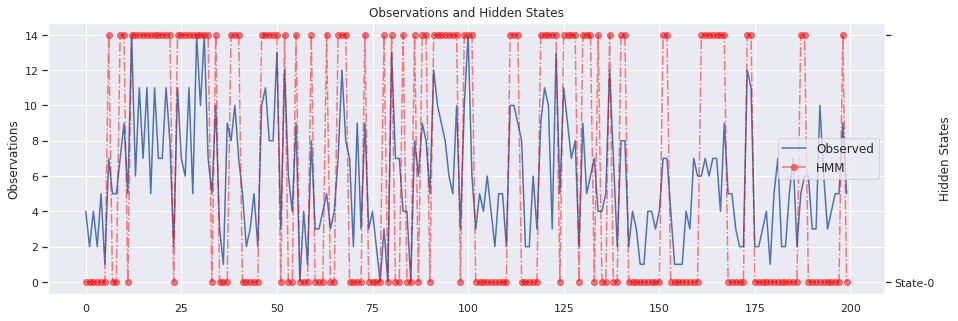

In [41]:
_ = plots.plot_hmm_states(observed_1[0], hidden_1[0])

### Sample Sequence from Model 1

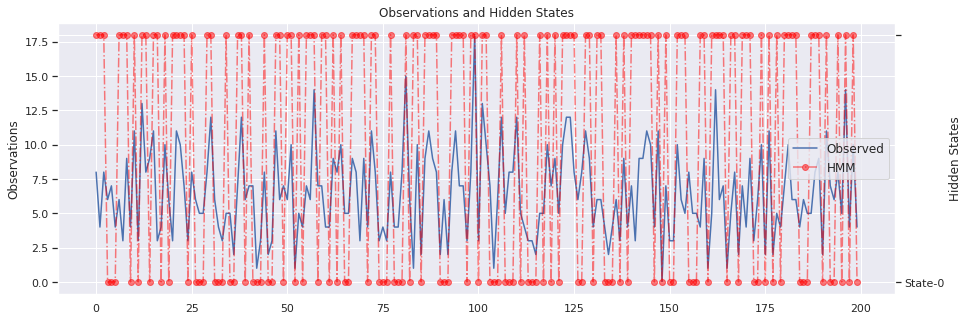

In [42]:
_ = plots.plot_hmm_states(observed_2[0], hidden_2[0])

In [43]:
train_observations, test_observations, train_labels, test_labels = sample_and_split([model_1, model_2])

In [45]:
clusterer = HMMCluster.HMMDistanceCluster(
        n_clusters=2, 
    hmm_impl=PoissonHMM.PoissonHMM(n_components=2, n_iterations=500, tol=1e-6, n_inits=1, verbose=0),
)

In [46]:
clusterer.fit(train_observations)


../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or c

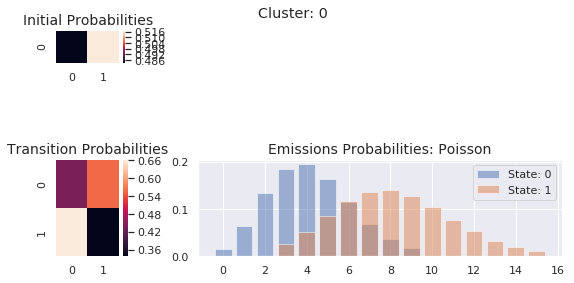

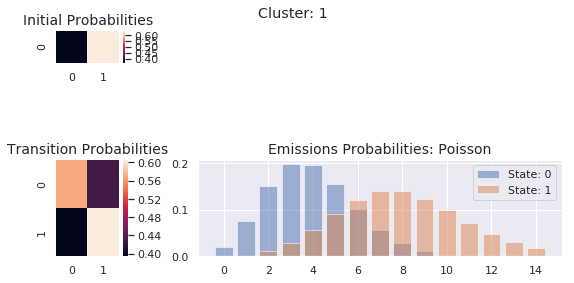

In [47]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.poisson_hinton_diagram(
        m.pi_,
        m.A_,
        m.means_,
    )
    fig.suptitle("Cluster: {}".format(i))

In [48]:
predictions = clusterer.predict(test_observations)
train_prediction = clusterer.predict(train_observations)

In [49]:
pd.crosstab(train_prediction, train_labels)

col_0   0   1
row_0        
0       1  25
1      29   5

In [50]:
HMMCluster.cluster_report(train_labels, train_prediction)

Mutual Info	0.386
Norm Mutual Info	0.560
Rand Score	0.634
Completeness	0.564
V-Measure	0.560


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [51]:
pd.crosstab(predictions, test_labels)

col_0   0   1
row_0        
0       8  63
1      62   7

In [52]:
HMMCluster.cluster_report(test_labels, predictions)

Mutual Info	0.353
Norm Mutual Info	0.509
Rand Score	0.615
Completeness	0.509
V-Measure	0.509


In [53]:
pd.crosstab(predictions, test_labels)

col_0   0   1
row_0        
0       8  63
1      62   7

## Categorical

In [54]:
pi_1 = [.5, .5]

A_1 = [[.6, .4],
       [.4, .6]]

pi_2 = pi_1
A_2 = [[.4, .6],
      [.6, .4]]
B_1 = [[.5, .5, 0],
       [.2, 0, .8]]
B_2 = [[.5, .4, .1],
       [.25, .25, .5]]

In [55]:

model_1 = CategoricalHMM.CategoricalHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_1.pi_ = pi_1
model_1.A_ = A_1
model_1.B_ = B_1

model_2 = CategoricalHMM.CategoricalHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_2.pi_ = pi_2
model_2.A_ = A_2
model_2.B_ = B_2


In [56]:
observed_1, hidden_1 = model_1.sample(1, 200)
observed_2, hidden_2 = model_2.sample(1, 200)

In [57]:
train_observations, test_observations, train_labels, test_labels = sample_and_split([model_1, model_2])

In [59]:
clusterer = HMMCluster.HMMDistanceCluster(
    n_clusters=2, 
    hmm_impl=CategoricalHMM.CategoricalHMM(n_components=2, n_iterations=100, tol=1e-6, n_inits=1),
)

In [60]:
clusterer.fit(train_observations)

../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or c

../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.loglikelihoods_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/HMMBase.py:141: UserWarning: Training did not converge! Consider running for more iterations or c

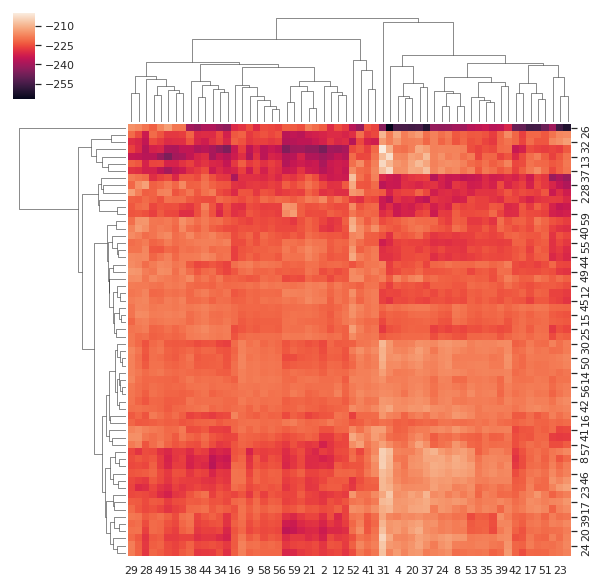

In [61]:
sns.clustermap(clusterer.original_lls_)

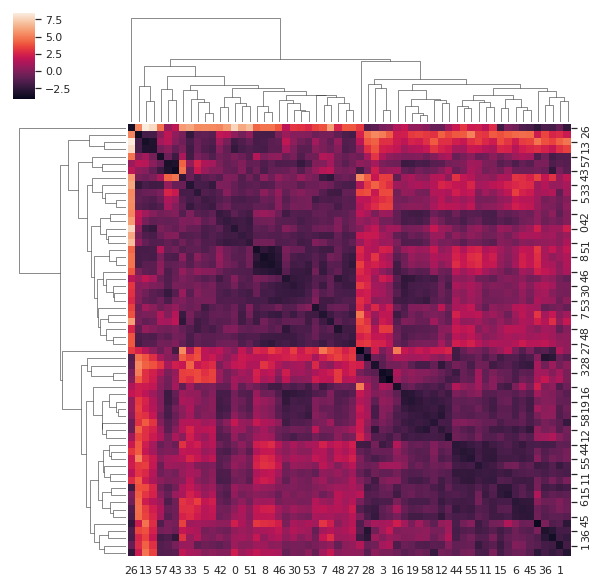

In [62]:
sns.clustermap(clusterer.lls_)

In [63]:
train_predictions = clusterer.predict(train_observations)
predictions = clusterer.predict(test_observations)

In [64]:
pd.crosstab(train_labels, train_predictions)

col_0   0   1
row_0        
0       2  28
1      30   0

In [65]:
pd.crosstab(test_labels, predictions)

col_0   0   1
row_0        
0       4  66
1      69   1

In [67]:
HMMCluster.cluster_report(test_labels, predictions)

Mutual Info	0.545
Norm Mutual Info	0.787
Rand Score	0.861
Completeness	0.788
V-Measure	0.787


/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


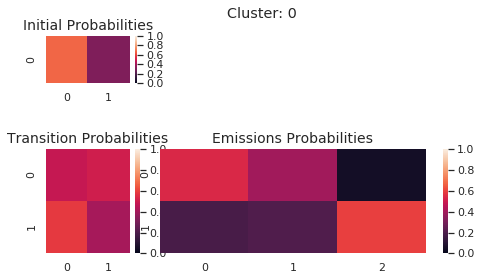

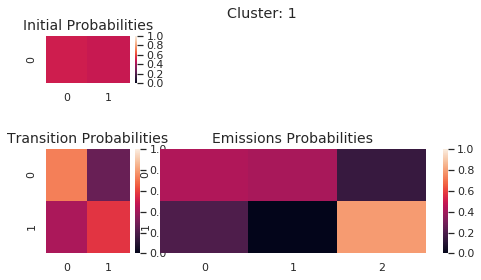

In [68]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.hinton_diagram(
        m.pi_,
        m.A_,
        m.B_,
        vmin=0,
        vmax=1
    )
    fig.suptitle("Cluster: {}".format(i))

### Categorical Variational

In [69]:
pi_1 = [.5, .5]

A_1 = [[.6, .4],
       [.4, .6]]

pi_2 = [.5, .5, .25]
A_2 = [[.4, .2, .4],
      [.2, .4, .2],
      [.1, .1, .8]]

B_1 = [[.5, .5, 0],
       [.2, 0, .8]]
B_2 = [[.5, .4, .1],
       [.25, .25, .5],
       [.1, .1, 8]]

In [70]:

model_1 = CategoricalHMM.CategoricalHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_1.pi_ = pi_1
model_1.A_ = A_1
model_1.B_ = B_1

model_2 = CategoricalHMM.CategoricalHMM(init_pi=None, init_A=None, init_emissions=None, n_iterations=0)
model_2.pi_ = pi_2
model_2.A_ = A_2
model_2.B_ = B_2


In [71]:
from hmm import CategoricalVariationalHMM

In [80]:
clusterer = HMMCluster.HMMDistanceCluster(
    n_clusters=2, 
    n_iterations_1=200,
    n_iterations_2=500,
    hmm_impl=CategoricalVariationalHMM.CategoricalVariationalHMM(
        n_components=3, 
        n_iterations=1000, 
        tol=1e-6, 
        n_inits=2
    ),
)

In [81]:
clusterer.fit(train_observations)

../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge

In [82]:
predicted = clusterer.predict(train_observations)

In [83]:
pd.crosstab(predicted, train_labels)

col_0   0   1
row_0        
0      24   0
1       6  30

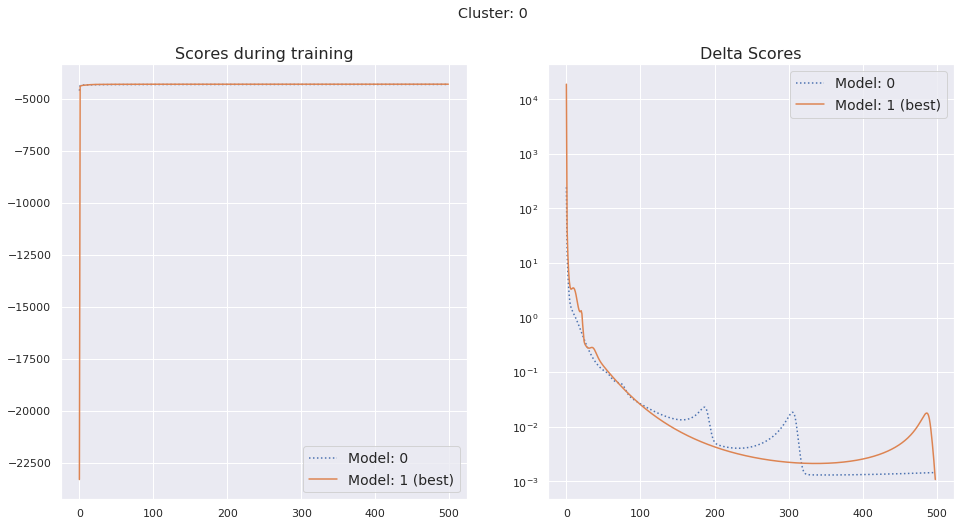

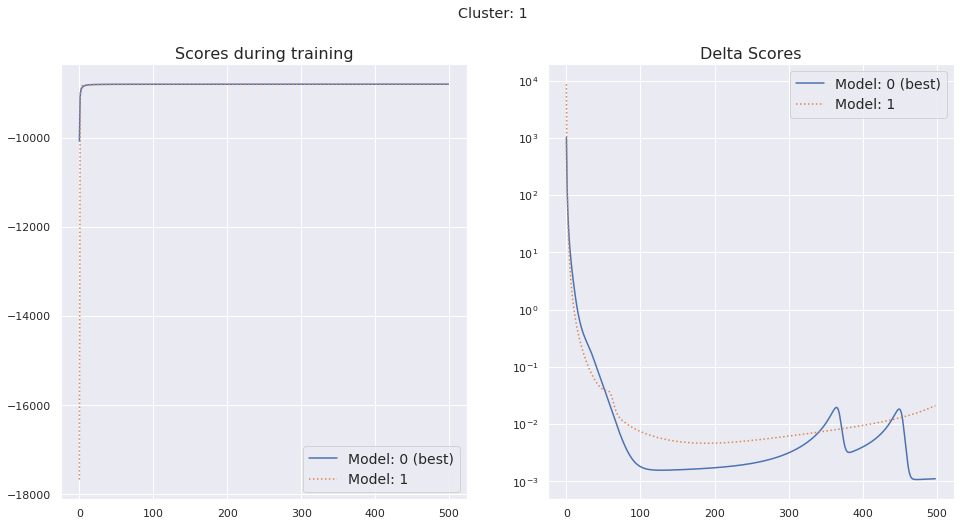

In [84]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.multiple_learning_plot(m.explored_free_energies_)
    fig.suptitle("Cluster: {}".format(i))

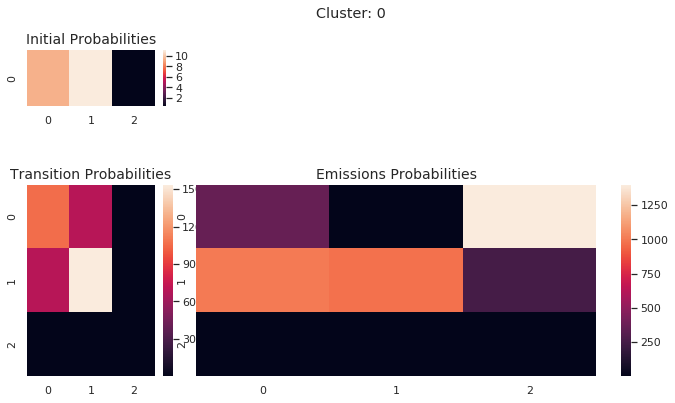

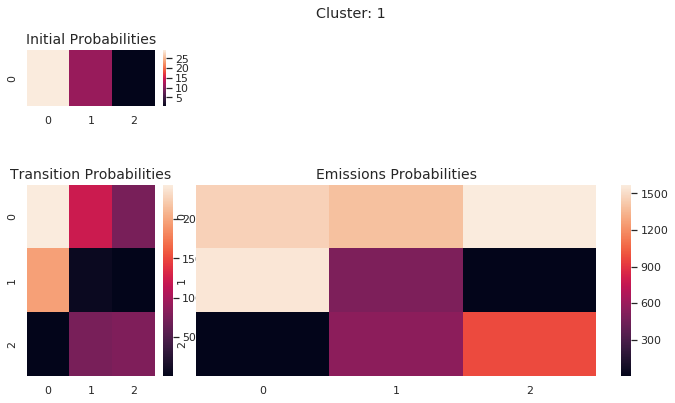

In [85]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.hinton_diagram(
        m.pi_counts_,
        m.A_counts_,
        m.B_counts_
    )
    fig.suptitle("Cluster: {}".format(i))

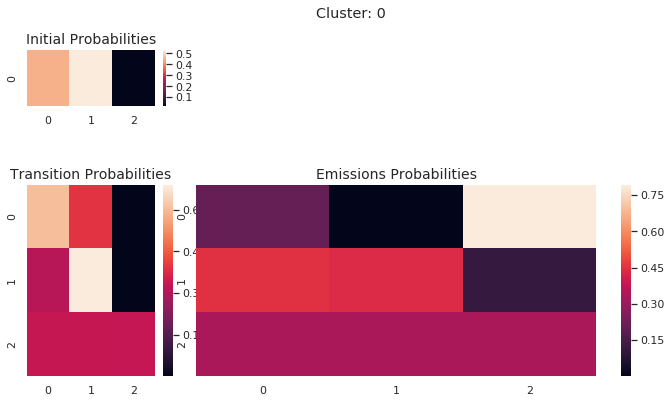

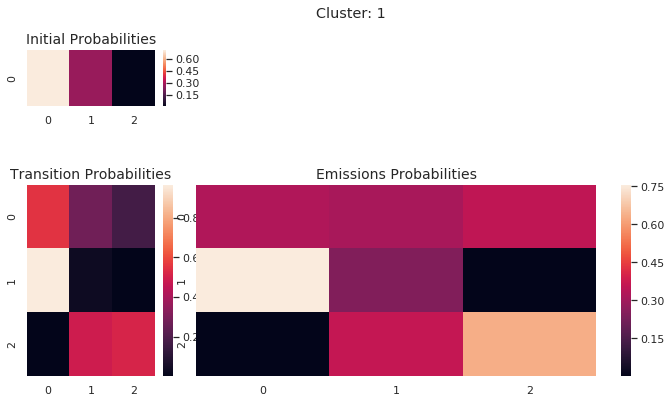

In [86]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.hinton_diagram(
        m.pi_normalized_,
        m.A_normalized_,
        m.B_normalized_
    )
    fig.suptitle("Cluster: {}".format(i))

### Variational Gaussian

In [87]:
pi_1 = [.5, .25, .25]
A_1 = [
    [.6, .2, .2],
    [.2, .6, .2],
    [.2, .2, .6]
]
means_1 = [11, 5, 8]
vars_1 = np.sqrt([.25, .25, .25])

pi_2 = np.full((3), 1/3)
A_2 = [
    [.2, .4, .4],
    [.4, .2, .4],
    [.4, .4, .2]
]
means_2 = means_1
vars_2 = vars_1



In [88]:
model_3 = synthetic.get_gaussian_mcgrory_and_titterington_model()

In [89]:
model_3

GaussianHMM(allowed_to_use_log=True, implementation='scaling', init_A=None,
      init_emissions=None, init_pi=None, n_components=1, n_inits=1,
      n_iterations=100, n_jobs=-1, random_state=None, tol=1e-06,
      variance_regularization=1e-06, verbose=0)

In [90]:

model_1 = GaussianHMM.GaussianHMM(init_pi=None, init_A=None, init_emissions=None)
model_1.pi_ = pi_1
model_1.A_ = A_1
model_1.means_ = means_1
model_1.variances_ = vars_1
model_2 = GaussianHMM.GaussianHMM(init_pi=None, init_A=None, init_emissions=None)
model_2.pi_ = pi_2
model_2.A_ = A_2
model_2.means_ = means_2
model_2.variances_ = vars_2

In [91]:
model_1_sequences = model_1.sample(10, 100)[0]
model_2_sequences = model_2.sample(10, 100)[0]
model_3_sequences = model_3.sample(10, 100)[0]

In [92]:
t1 = GaussianVariationalHMM.GaussianVariationalHMM(n_components=4, n_iterations=500)
t1.fit(model_1_sequences)

GaussianVariationalHMM(A_prior=None, implementation='scaling',
            means_prior='uninformed', min_a_value=None, n_components=4,
            n_inits=1, n_iterations=500, n_jobs=-1, n_samples_prior=None,
            pi_prior=None, random_state=None, tol=1e-06,
            variances_prior='uninformed', verbose=0)

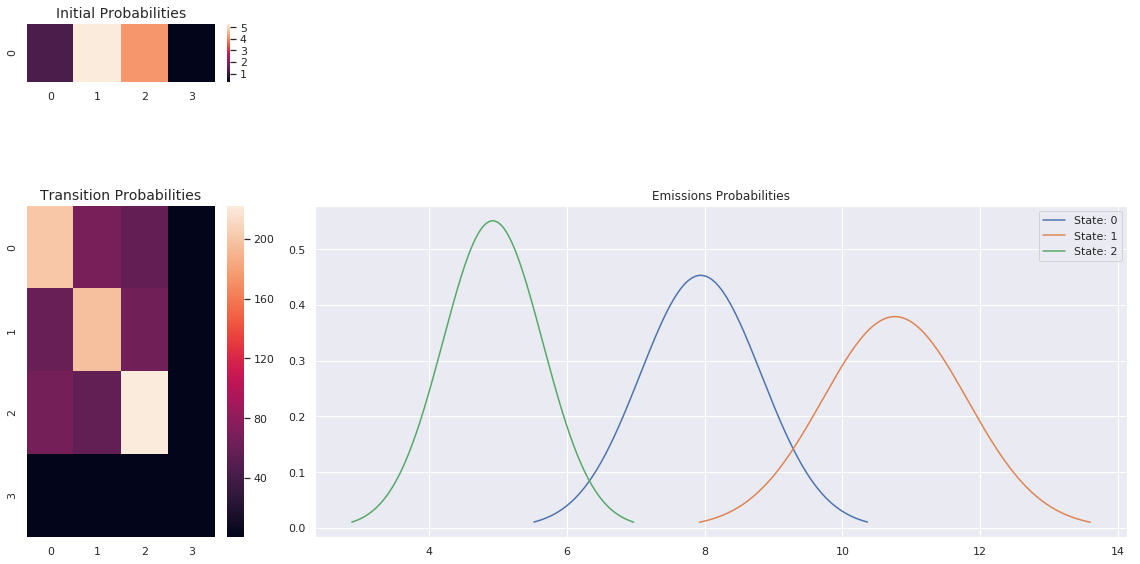

In [93]:
_ = plots.gaussian_hinton_diagram(
    t1.pi_counts_,
    t1.A_counts_,
    t1.means_posterior_,
    t1.variances_posterior_)

In [94]:
t2 = GaussianVariationalHMM.GaussianVariationalHMM(n_components=4, n_iterations=500)
t2.fit(model_2_sequences)

GaussianVariationalHMM(A_prior=None, implementation='scaling',
            means_prior='uninformed', min_a_value=None, n_components=4,
            n_inits=1, n_iterations=500, n_jobs=-1, n_samples_prior=None,
            pi_prior=None, random_state=None, tol=1e-06,
            variances_prior='uninformed', verbose=0)

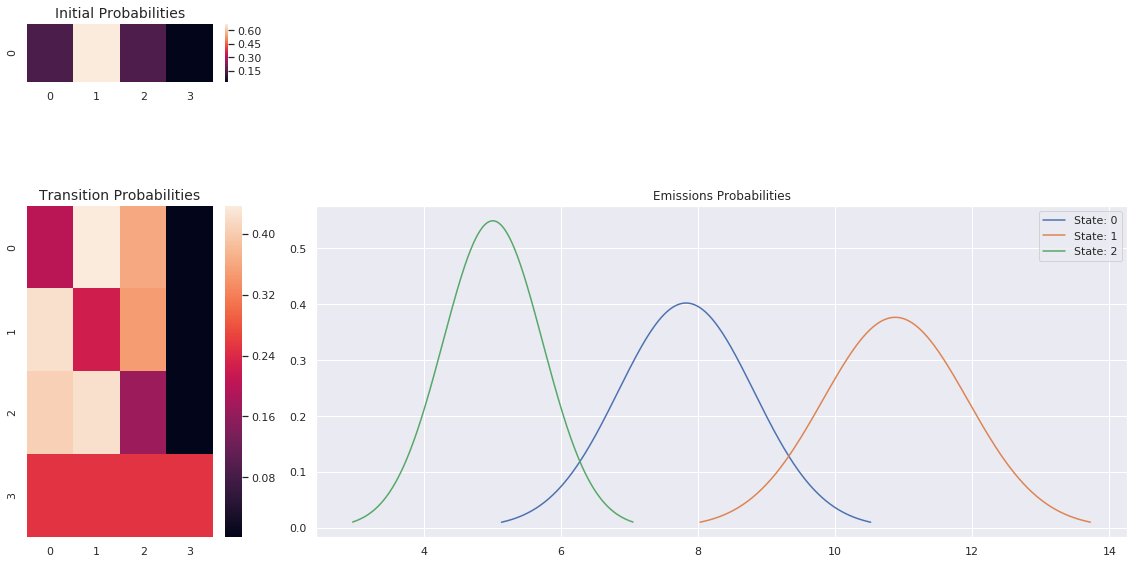

In [95]:
_ = plots.gaussian_hinton_diagram(
    t2.pi_normalized_,
    t2.A_normalized_,
    t2.means_posterior_,
    t2.variances_posterior_)

In [96]:
t3 = GaussianVariationalHMM.GaussianVariationalHMM(n_components=5, n_iterations=500, n_inits=5)
t3.fit(model_3_sequences)

GaussianVariationalHMM(A_prior=None, implementation='scaling',
            means_prior='uninformed', min_a_value=None, n_components=5,
            n_inits=5, n_iterations=500, n_jobs=-1, n_samples_prior=None,
            pi_prior=None, random_state=None, tol=1e-06,
            variances_prior='uninformed', verbose=0)

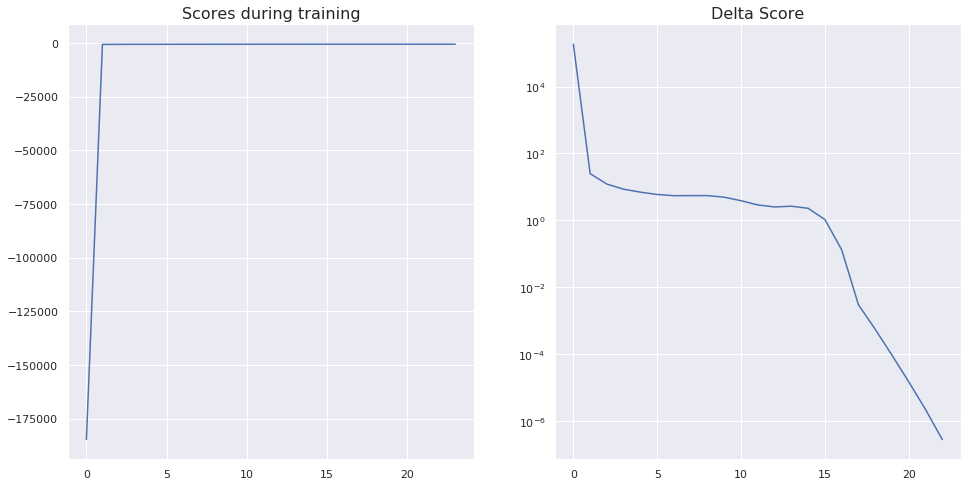

In [97]:
_ = plots.learning_plot(t3.lower_bound_)

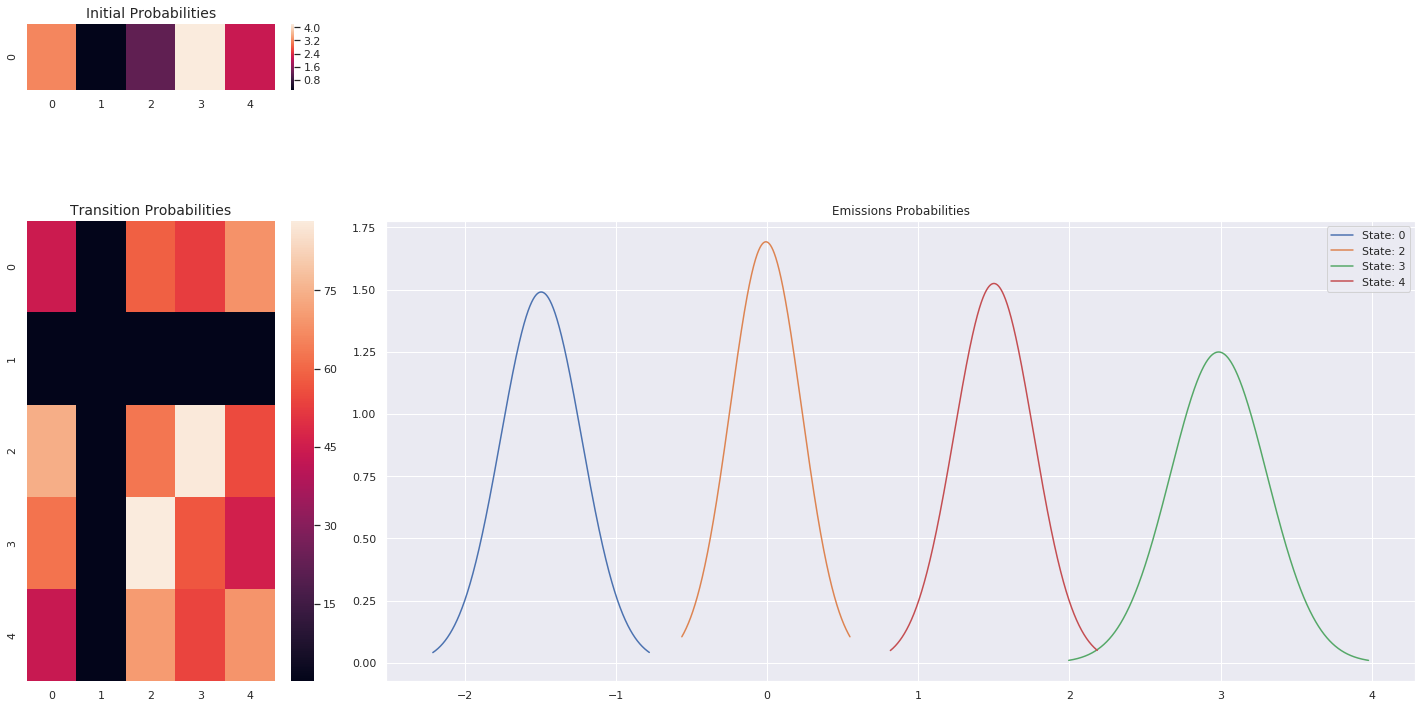

In [98]:
_ = plots.gaussian_hinton_diagram(
    t3.pi_counts_,
    t3.A_counts_,
    t3.means_posterior_,
    t3.variances_posterior_)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


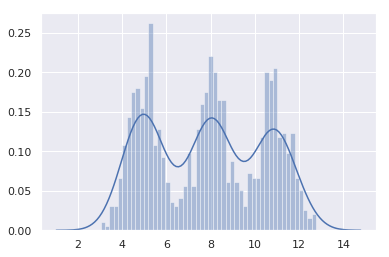

In [99]:
sns.distplot(model_1_sequences.ravel(), bins=50)

In [100]:
train_observations, test_observations, train_labels, test_labels = sample_and_split([model_1, model_2, model_3])

In [101]:
train_observations.shape

(90, 200)

/home/matthew/pkgsrc/install.20190210/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


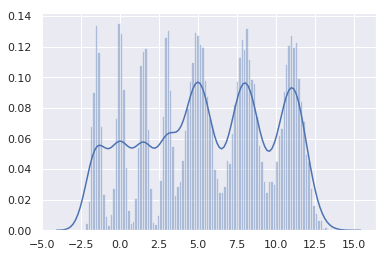

In [102]:
sns.distplot(train_observations.ravel(), bins=100)

In [104]:
clusterer = HMMCluster.HMMDistanceCluster(
    n_clusters=4, 
    n_iterations_1=500,
    n_iterations_2=500,
    hmm_impl=GaussianVariationalHMM.GaussianVariationalHMM(
        n_components=4, 
        n_iterations=1000, 
        tol=1e-6, 
        n_inits=4
    ),
)

In [105]:
clusterer.fit(train_observations)

../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge! Consider running for more iterations or choosing different starting values
  self.lower_bound_ = trainer.train(X, iterations=self.n_iterations, tol=self.tol)
../hmm/VariationalHMMBase.py:153: UserWarning: Training did not converge

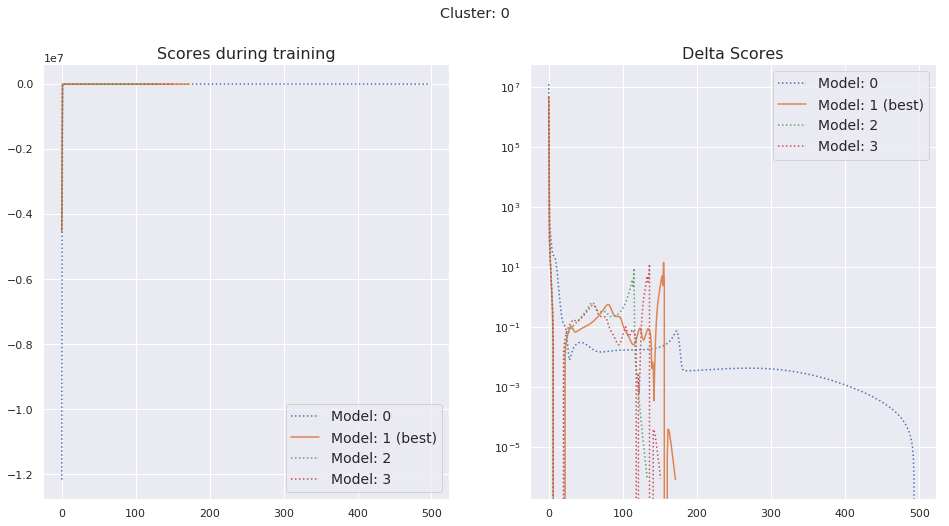

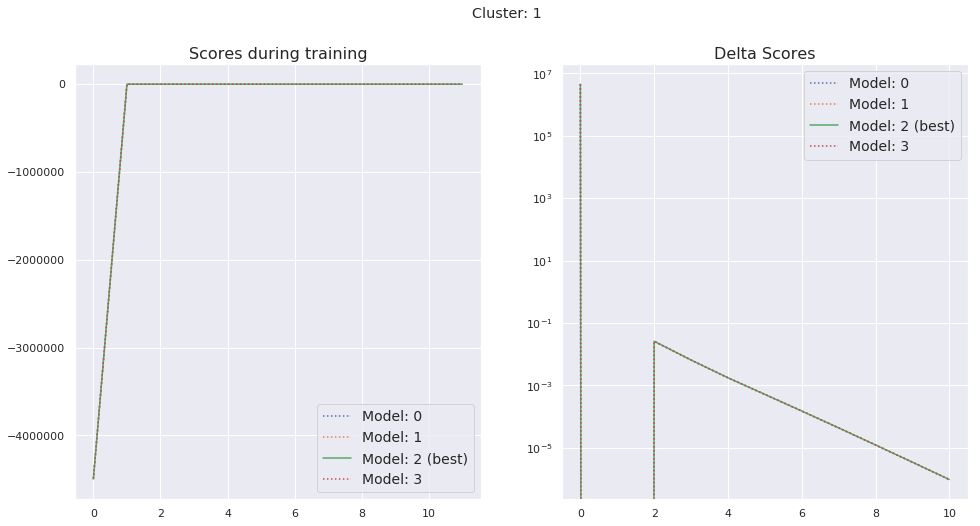

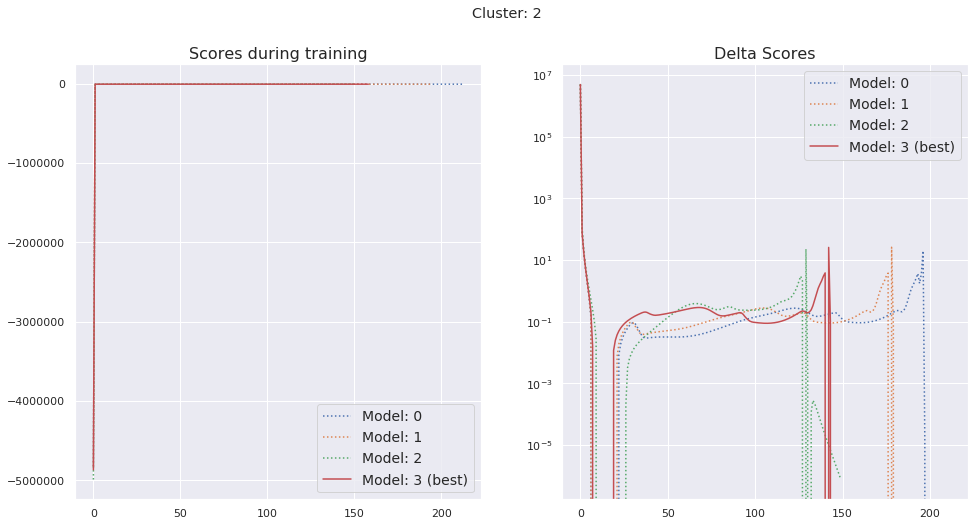

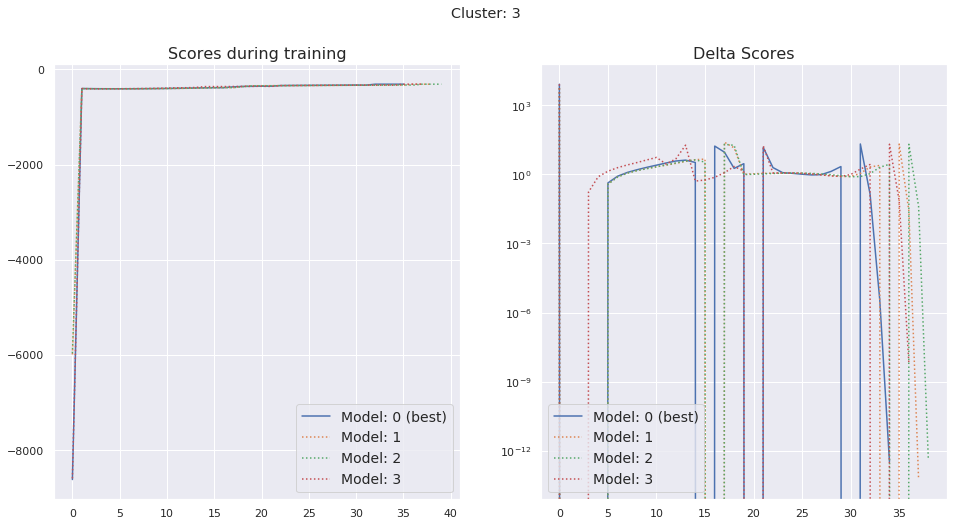

In [106]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.multiple_learning_plot(m.explored_free_energies_)
    fig.suptitle("Cluster: {}".format(i))

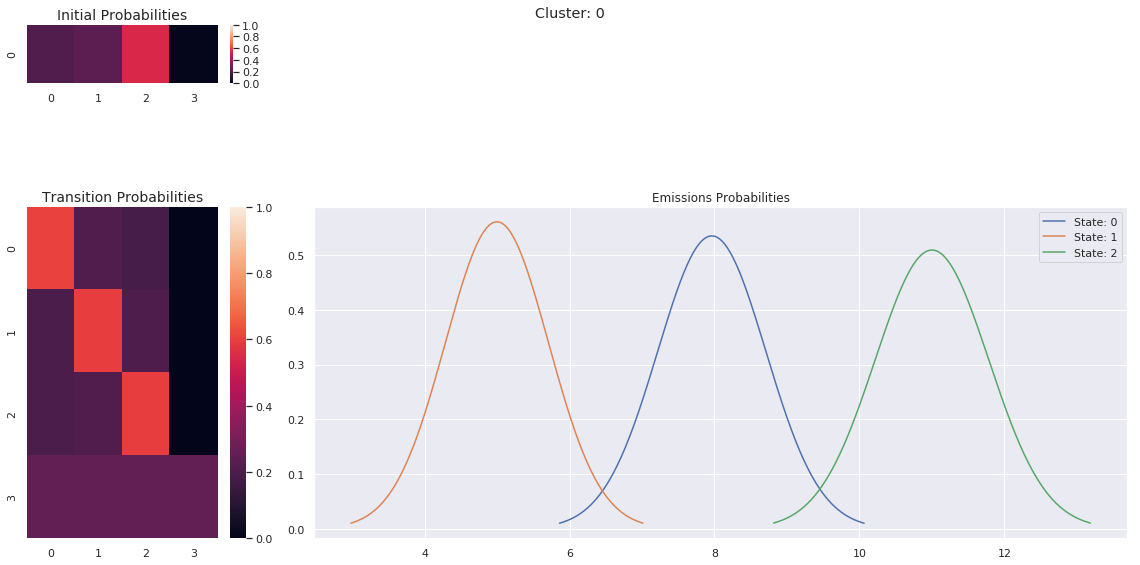

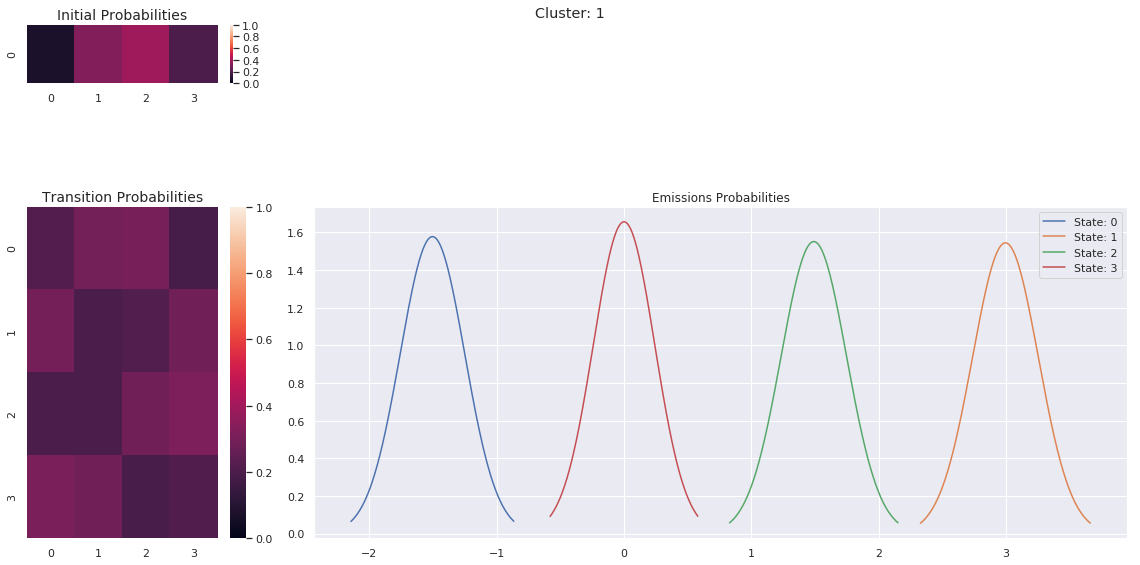

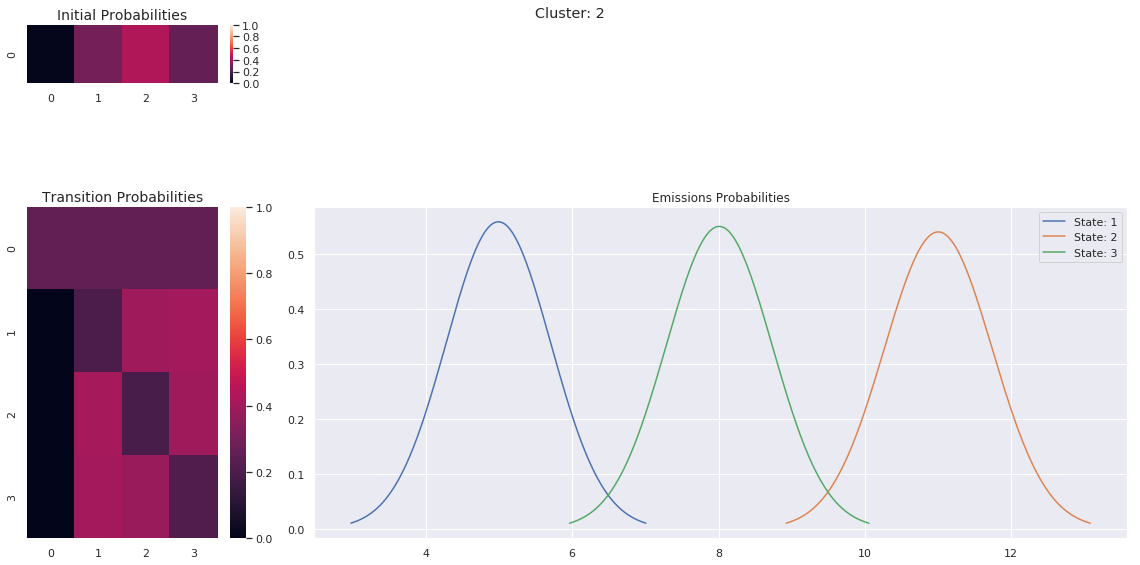

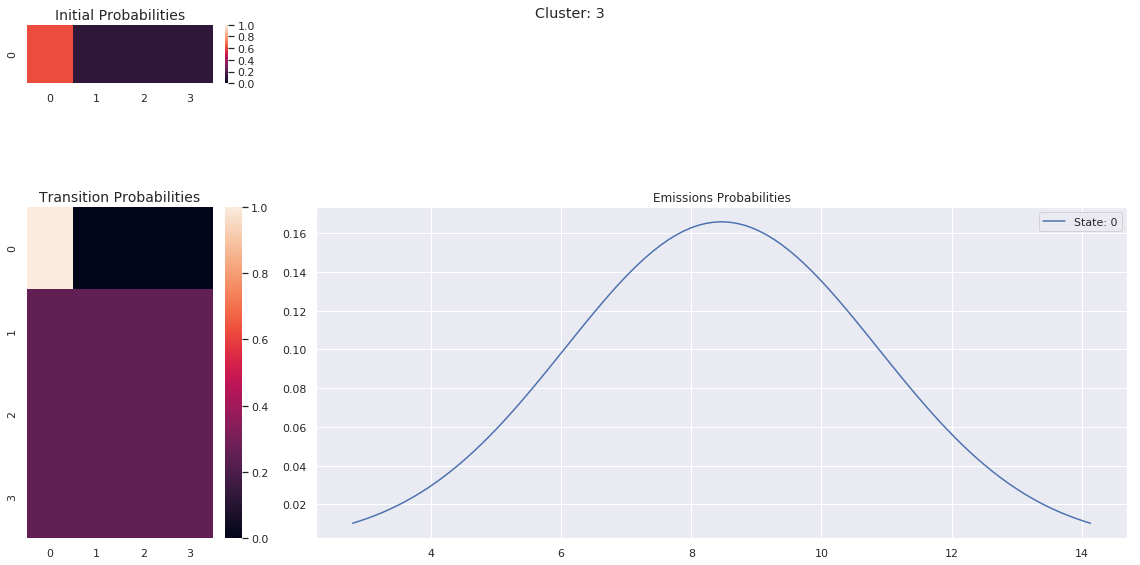

In [107]:
for i in range(clusterer.n_clusters):
    m = clusterer.grouped_models_[i]
    fig = plots.gaussian_hinton_diagram(
        m.pi_normalized_,
        m.A_normalized_,
        m.means_posterior_,
        m.variances_posterior_,
        vmin=0,
        vmax=1
    )
    fig.suptitle("Cluster: {}".format(i))

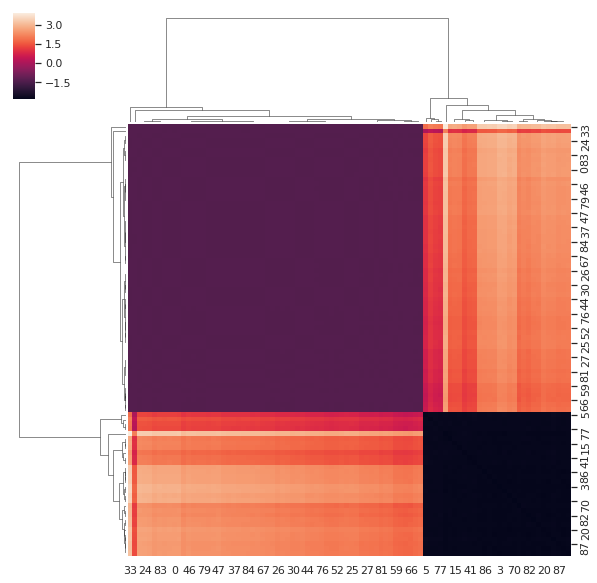

In [108]:
sns.clustermap(clusterer.lls_, method="average")

In [109]:
pd.crosstab(train_labels, clusterer.predict(train_observations))

col_0   0   1   2
row_0            
0      30   0   0
1       0   0  30
2       0  30   0

In [110]:
predicted_test = clusterer.predict(test_observations)

In [111]:
predicted_test

array([0, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 2, 1, 1, 2, 1, 2, 0, 0, 2,
       0, 2, 1, 1, 2, 1, 1, 2, 0, 2, 1, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 1,
       0, 0, 2, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 1,
       0, 2, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2,
       1, 1, 1, 1, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0,
       1, 2, 2, 1, 0, 0, 2, 1, 2, 2, 1, 2, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1,
       2, 1, 0, 2, 0, 0, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0,
       2, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 0,
       2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 1, 2])

In [112]:
pd.crosstab(test_labels, predicted_test)

col_0   0   1   2
row_0            
0      70   0   0
1       0   0  70
2       0  70   0

In [114]:
non_variational = HMMCluster.HMMDistanceCluster(
    n_clusters=3, 
    n_jobs=4,
    hmm_impl=GaussianHMM.GaussianHMM(
        n_components=4, 
        n_iterations=1000, 
        tol=1e-6, 
        n_inits=2
    ),
)

In [115]:
non_variational.fit(train_observations)

In [116]:
predicted_test = non_variational.predict(test_observations)
pd.crosstab(test_labels, predicted_test)

col_0   0   1   2
row_0            
0       0   0  70
1      70   0   0
2       0  70   0

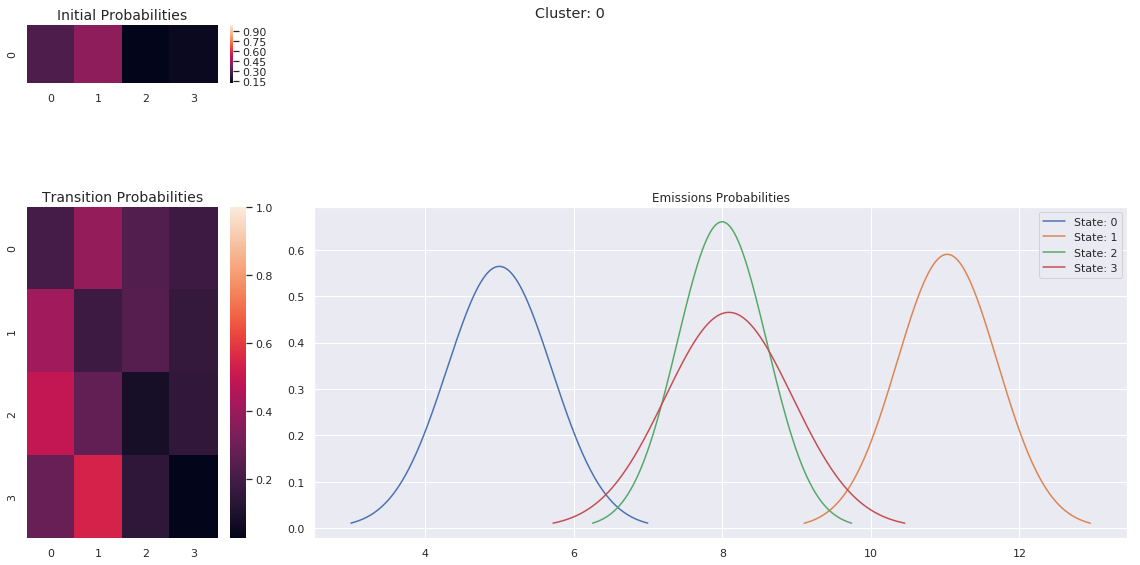

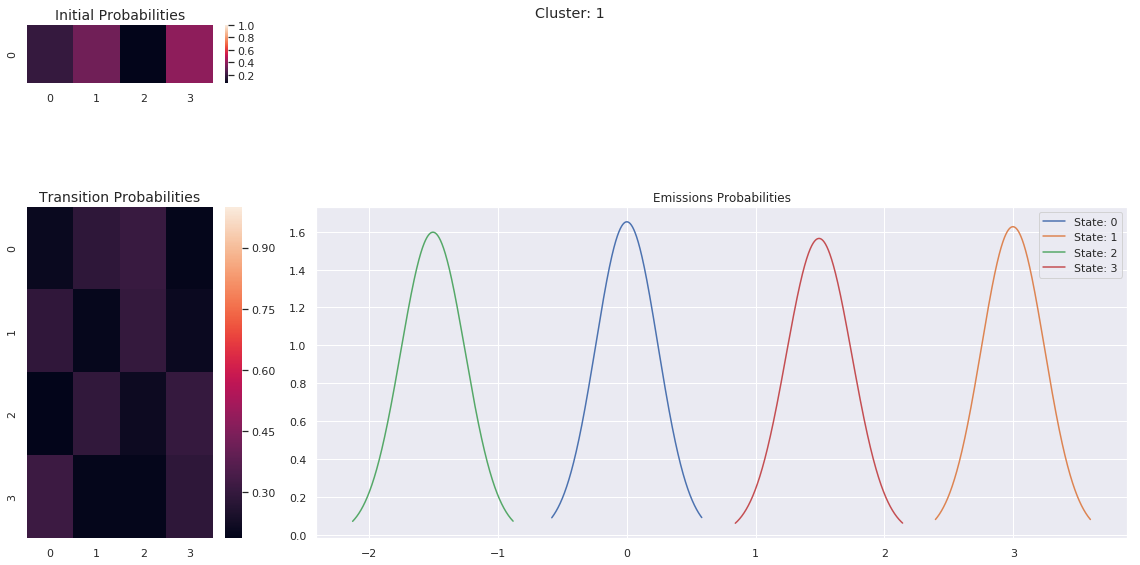

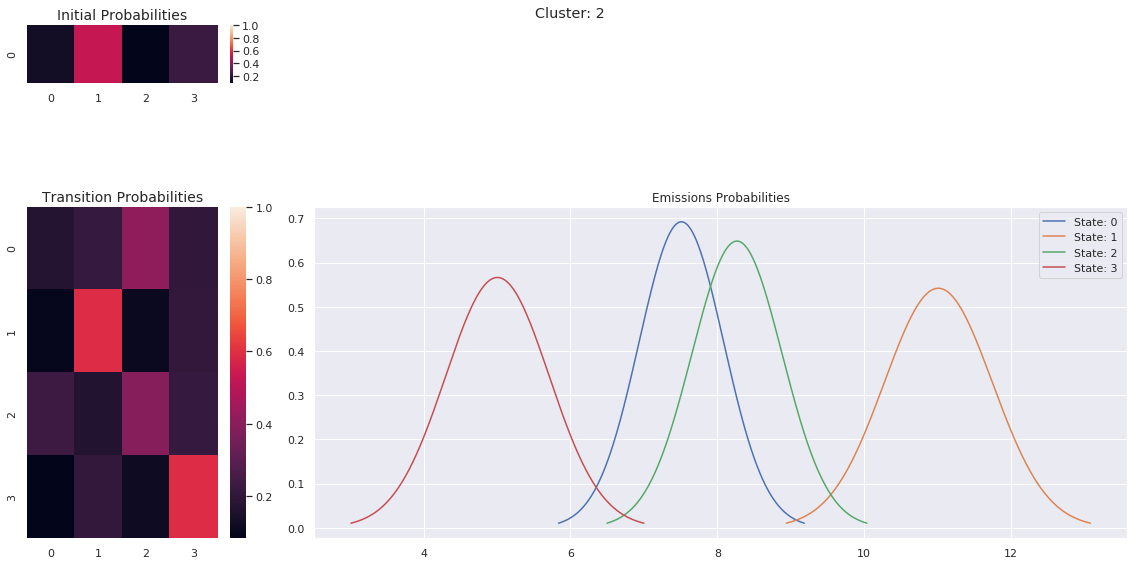

In [117]:
for i in range(non_variational.n_clusters):
    m = non_variational.grouped_models_[i]
    fig = plots.gaussian_hinton_diagram(
        m.pi_,
        m.A_,
        m.means_,
        m.variances_,
        vmax=1
    )
    fig.suptitle("Cluster: {}".format(i))